In [1]:
%matplotlib widget

In [2]:
import numpy as np
import random
import pickle
import time
from tqdm import tqdm
from matplotlib import pyplot as plt


In [3]:

#@title Functions for generating inputs and states

# Defining different reservoirs to experiment with

    

# function which compiles the steps to generate inputs and reservoir states
# input: reservoir function (optional, will default to tanh)
def generate_states_lorenz(params,
                           num_steps=100000, dt=0.0001,
                           initial_conditions = (0., 1., 1.05)):
  def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

  xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
  xyzs[0] = initial_conditions  # Set initial values

  # x, y, z = [0] * 10001, [0] * 10001, [0] * 10001
  # x[0], y[0], z[0] = xyzs[0]

  # Step through "time", calculating the partial derivatives at the current point
  # and using them to estimate the next point
  print("Generating Inputs")
  for i in tqdm(range(num_steps)):
      xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

  # Parameters
  beta =params['beta']
  gamma = params['gamma']
  tau = params['tau']
  n = params['n']
#   beta = 2
#   gamma = 1
#   tau = 2
#   n = 9.65
  t_span = int(num_steps*dt)  # Time steps
  # dt = 0.01  # Time step size
  t = np.arange(0, t_span, dt)

  # Initial condition (you'll need to define this)
  h0 = 1.0
  h = np.zeros_like(t)
  h[0] = h0


  x_list = xyzs.T[0]
  
  # Numerical solution using Euler method
  for i in range(1, len(t)):
      h[i] = h[i-1] + dt * (beta * h[i-int(tau/dt)] / (1 + h[i-int(tau/dt)]**n) - gamma * h[i-1] + x_list[i-1])

  return xyzs, h

In [4]:
import time
from multiprocessing import Pool
import pickle

from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import pandas as pd

#@title Functions for training readout layer

def generate_offsets(input, reservoir_state, tau):
  if tau == 0:
    return input, reservoir_state[1:]
  elif tau > 0:
    return input[tau:], reservoir_state[1:-tau]
  else:
    return input[:tau], reservoir_state[1-tau:]

def train_model(x, y, model):
    # Flatten reservoir states for use as input features
    emissions = np.array(y)  # Target outputs (emissions)

    split_index = int(0.8 * len(x))  # 80% for training, 20% for testing

    # Split into training and testing sets
    X_train, X_test = x[:split_index], x[split_index:]
    emissions_train, emissions_test = y[:split_index], y[split_index:]

    # Initialize and train the regressor
    model = model # RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, emissions_train)

    # EVALUATING ON TRAINING
    emissions_pred_train = model.predict(X_train)
    r2_train =  r2_score(emissions_train, emissions_pred_train)
    mse_train = mean_squared_error(emissions_train, emissions_pred_train)

    # EVALUATE ON TESTING
    emissions_pred_test = model.predict(X_test)
    r2_test = r2_score(emissions_test, emissions_pred_test)
    mse_test = mean_squared_error(emissions_test, emissions_pred_test)

    return model, r2_train, r2_test, mse_train, mse_test

def testing_training_metrics(r2_train, r2_test, mse_train, mse_test):
  data = {
      " ": ["R^2", "MSE"],
      "Training": [r2_train, mse_train],
      "Testing": [r2_test, mse_test]
  }

  df = pd.DataFrame(data)

  return df

reservoir_type = "chaotic"

def f(tau):
        with open('x_list.pkl', 'rb') as file:
            x_list = pickle.load(file)
        with open('h_x_'+reservoir_type+'.pkl', 'rb') as file:
            h_x = pickle.load(file)
        y, x = generate_offsets(x_list, h_x, tau = tau)
        # print("Offset:", tau)
        # print("lengths:", len(y), len(x))
        x = [[i] for i in x] # fix dimensions
        model = LinearRegression()
        model,r2_train, r2_test, mse_train, mse_test = train_model(x, y, model)
        return r2_train

In [5]:
tau_range = range(-40000, 40000, 10000)

values = [0.01, 0.1, 0.5, 1, 5]

size = 10
betas = np.random.choice(values, size=size, replace=True)
gammas = np.random.choice(values, size=size, replace=True)
taus = [20 for i in range(size)]
ns = [10 for i in range(size)]


param_list = []
res = []
for i in range(len(betas)):
    params = {
        'beta':betas[i],
        'gamma': gammas[i],
        'tau': taus[i],
        'n': ns[i],
    }
    param_list.append(params)
    xyzs, h_list = generate_states_lorenz(params,
                                            num_steps=1000000, dt=0.0001,
                                            initial_conditions = (3, 3, 3))
    
    x_list = xyzs.T[0][2000:]
    y_list = xyzs.T[1][2000:]
    z_list = xyzs.T[2][2000:]
    h_list = h_list[1999:]

    mc_pc = []
    for t in tau_range:
        y, x = generate_offsets(x_list[1:], h_list, tau = t)
        # print("Offset:", tau)
        # print("lengths:", len(y), len(x))
        x = [[i] for i in x] # fix dimensions
        model = LinearRegression()
        model,r2_train, r2_test, mse_train, mse_test = train_model(x, y, model)
        mc_pc.append(r2_train)

    res.append(mc_pc)

Generating Inputs


100%|██████████| 1000000/1000000 [00:08<00:00, 118714.58it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 163886.50it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 164718.26it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 146383.35it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 161924.11it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 154239.60it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 152811.62it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 157389.33it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 161205.95it/s]


Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 153385.11it/s]


In [6]:
for i, params in enumerate(param_list):
    print(f'list {i}: {params}')

list 0: {'beta': 0.1, 'gamma': 0.01, 'tau': 20, 'n': 10}
list 1: {'beta': 0.5, 'gamma': 1.0, 'tau': 20, 'n': 10}
list 2: {'beta': 0.1, 'gamma': 0.1, 'tau': 20, 'n': 10}
list 3: {'beta': 1.0, 'gamma': 1.0, 'tau': 20, 'n': 10}
list 4: {'beta': 0.5, 'gamma': 0.01, 'tau': 20, 'n': 10}
list 5: {'beta': 5.0, 'gamma': 5.0, 'tau': 20, 'n': 10}
list 6: {'beta': 5.0, 'gamma': 0.5, 'tau': 20, 'n': 10}
list 7: {'beta': 0.01, 'gamma': 1.0, 'tau': 20, 'n': 10}
list 8: {'beta': 1.0, 'gamma': 0.1, 'tau': 20, 'n': 10}
list 9: {'beta': 0.01, 'gamma': 0.1, 'tau': 20, 'n': 10}


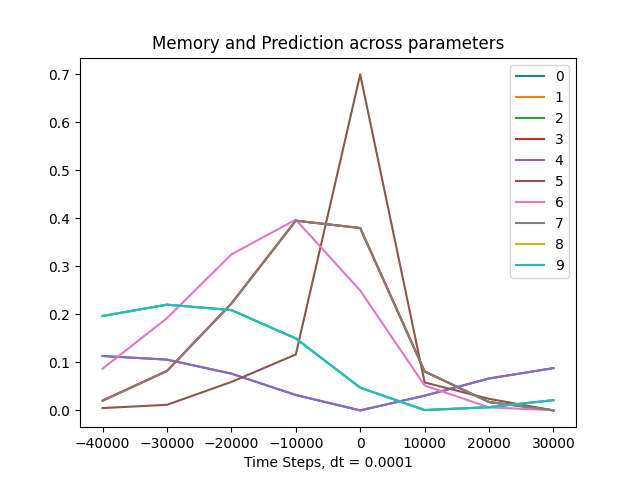

In [7]:
plt.figure()
for i in range(size):
    plt.plot(tau_range, res[i], label=i)
plt.xlabel('Time Steps, dt = 0.0001')
plt.title("Memory and Prediction across parameters")
plt.legend()
plt.show()

In [8]:
# input desired parameters to plot x,y against hidden state

params = {
        'beta':0.01,
        'gamma': .1,
        'tau': 20,
        'n': 10,
}
xyzs, h_list = generate_states_lorenz(params,
                                        num_steps=1000000, dt=0.0001,
                                        initial_conditions = (3, 3, 3))

Generating Inputs


100%|██████████| 1000000/1000000 [00:06<00:00, 155070.73it/s]


In [9]:
# params = {
#         'beta':1,
#         'gamma': .5,
#         'tau': 20,
#         'n': 10,
# }
# xyzs, h_list = generate_states_lorenz(params,
#                                         num_steps=1000000, dt=0.0001,
#                                         initial_conditions = (3, 3, 3))

In [10]:
# # x_list = xyzs.T[0][2000:]
# # y_list = xyzs.T[1][2000:]
# # z_list = xyzs.T[2][2000:]
# # h_list = h_list[1999:]
x_list = xyzs.T[0][20000:]
y_list = xyzs.T[1][20000:]
z_list = xyzs.T[2][20000:]
h_list = h_list[19999:]

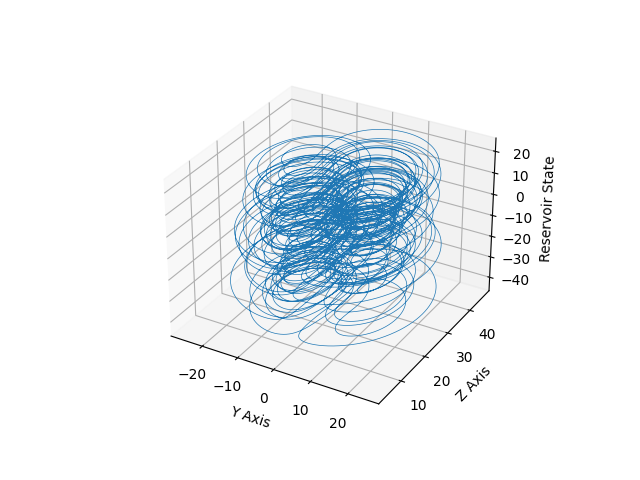

In [11]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(y_list, z_list, h_list, lw=0.5)
ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_zlabel("Reservoir State" )

plt.show()

In [12]:
# ax = plt.figure().add_subplot(projection='3d')

# ax.plot(y_list, z_list, x_list, lw=0.5)
# ax.set_xlabel("Y Axis")
# ax.set_ylabel("Z Axis")
# ax.set_zlabel("X")

# plt.show()